# MLG Mieleros chillones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Capítulo 1: exploración del dataset

In [3]:
df = pd.read_csv("./nminer.csv")

Text(0.5, 1.0, 'Explorando nminer: mieleros v eucaliptos ')

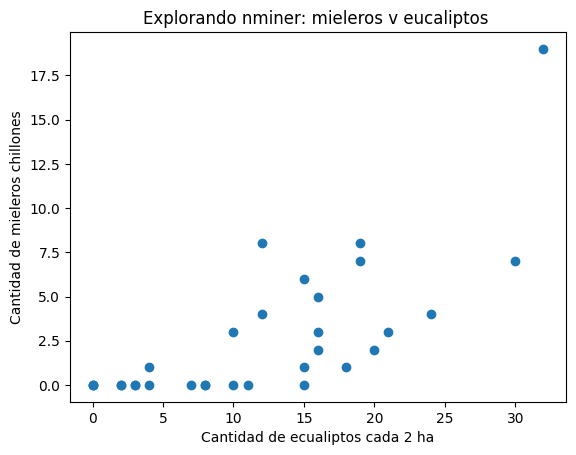

In [4]:
fig, ax = plt.subplots()
ax.scatter(df["Eucs"],df["Minerab"])
ax.set_xlabel("Cantidad de ecualiptos cada 2 ha")
ax.set_ylabel("Cantidad de mieleros chillones")
ax.set_title("Explorando nminer: mieleros v eucaliptos ")

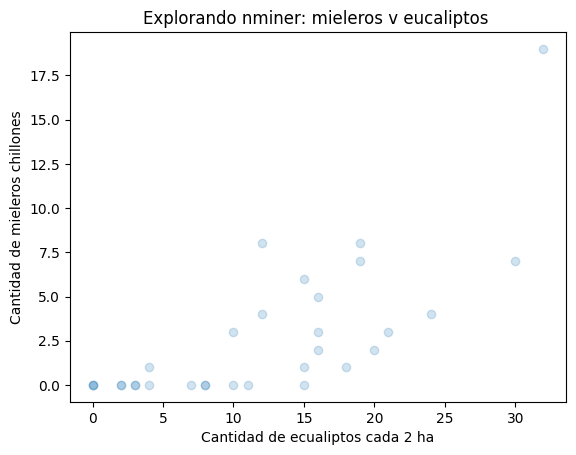

In [5]:
# Transparencia
fig, ax = plt.subplots()
ax.scatter(df["Eucs"], df["Minerab"], alpha=0.2)
ax.set_xlabel("Cantidad de ecualiptos cada 2 ha")
ax.set_ylabel("Cantidad de mieleros chillones")
ax.set_title("Explorando nminer: mieleros v eucaliptos ")
plt.show()

### Veamos cómo cambia la varianza en función de la media

C:\Users\Usuario\AppData\Local\Temp\ipykernel_29904\2394865769.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('Eucs_cut')['Minerab']


              Group size  Group mean  Group variance
Eucs_cut                                            
(-inf, 4.5]            9    0.111111        0.111111
(4.5, 11.5]            6    0.500000        1.500000
(11.5, 15.5]           5    3.800000       11.200000
(15.5, 19.5]           6    4.333333        7.866667
(19.5, inf]            5    7.000000       48.500000
b1 = 1.2895845107357207


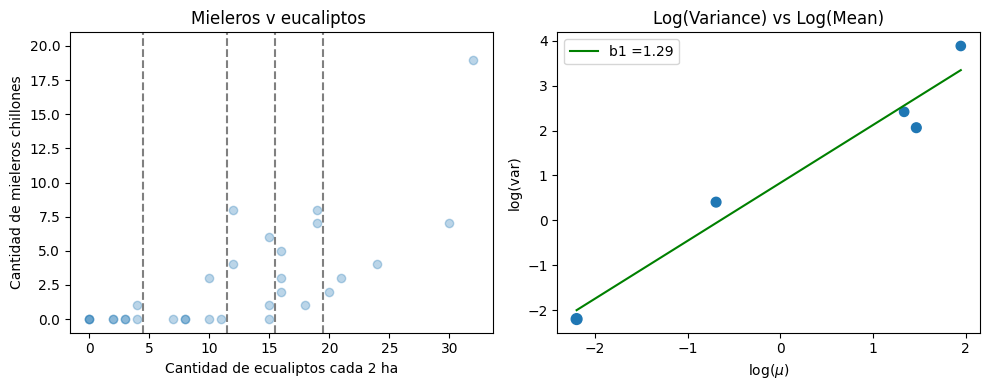

In [6]:
breaks = [-np.inf, 4.5, 11.5, 15.5, 19.5, np.inf]

# Dividir los datos en grupos según el número de eucaliptos
df['Eucs_cut'] = pd.cut(df['Eucs'], bins=breaks)

# Calculo la media, varianza y tamaño de cada grupo de mineros
grouped = df.groupby('Eucs_cut')['Minerab']
means = grouped.mean()
variances = grouped.var()
sizes = grouped.size()

# Mostrar el resultado en formato de tabla
summary = pd.DataFrame({
    'Group size': sizes,
    'Group mean': means,
    'Group variance': variances
})
print(summary)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(df["Eucs"], df["Minerab"], alpha=0.3)
ax[0].vlines([4.5, 11.5, 15.5, 19.5], ymin=-1, ymax=21, linestyles='dashed', colors='gray')
ax[0].set_xlabel("Cantidad de ecualiptos cada 2 ha")
ax[0].set_ylabel("Cantidad de mieleros chillones")
ax[0].set_title("Mieleros v eucaliptos ")
ax[0].set_ylim(-1,21)


x,y = np.log(means), np.log(variances)
x_intercept = np.column_stack((np.ones_like(x),x))
b0, b1 = np.linalg.inv(x_intercept.T @ x_intercept) @ x_intercept.T @ y
print('b1 =',b1)

x_range = np.linspace(x.min(),x.max(),1000)
ax[1].scatter(np.log(means), np.log(variances),s=0.2 * np.sqrt(sizes) * 100)
ax[1].plot(x_range,b1*x_range+b0,color='g',label=f'b1 ={b1:.2f}')
ax[1].set_xlabel(r'log($\mu$)')
ax[1].set_ylabel(r'log(var)')
ax[1].set_title('Log(Variance) vs Log(Mean)')
ax[1].legend()

plt.tight_layout()
plt.show()

## Capítulo 2: Proponer un GLM

Propongo el modelo:
$$Y \sim Poisson(\mu) $$
$$ \eta = \log(\mu) = \beta_0 + \beta_1X $$

Como vimos, Poisson es una distribución de la familia exponencial con $\theta = \log(\mu)$, $\kappa(\theta) = \mu = e^{\theta}$ y $\phi = 1$



## Capítulo 3: Ajustar este MLG
Es decir, encontrar estimaciones puntuales para los parámetros de regresión $\beta_0$ y $\beta_1$

La likelihood es $$ \mathcal{L}(\mu) = \prod_{i=1}^{n}a(y) e^{y_i\log(\mu) -\mu}$$

donde $\mu = \mu(\beta_0,\beta_1) = e^{\beta_0 + \beta_1x_i}$. Entonces maximizar $\mathcal{L}(\mu)$ es lo mismo que minimizar $-\log(\mathcal{L}(\mu)) $ y eso es lo que hago en el código.

In [7]:
def neg_log_likelihood_poisson(beta, X, Y):
    mu_ = np.exp(np.dot(X, beta)) #la funcion de vinculo
    return -np.sum(Y*np.log(mu_) - mu_)

b0 =  -0.8762104362748944
b1 =  0.11398130176453514


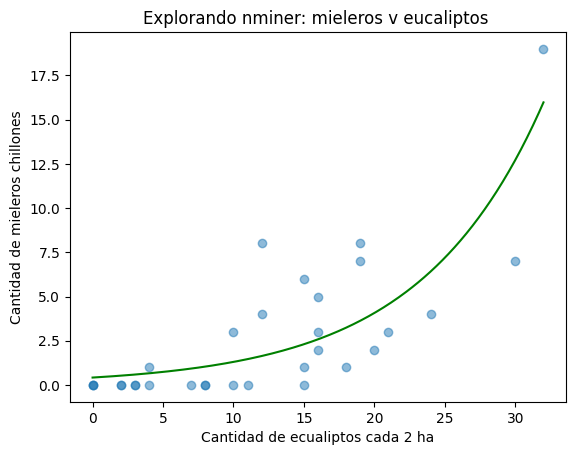

In [8]:
from scipy.optimize import minimize
from numpy.linalg import inv

X,Y = df["Eucs"], df["Minerab"]

intercept = np.ones(X.shape)
X_with_intercept = np.column_stack((intercept,X))

initial_beta = np.zeros(X_with_intercept.shape[1])
res_poisson = minimize(neg_log_likelihood_poisson, initial_beta, args=(X_with_intercept, Y))

b0 = res_poisson.x[0]
b1 = res_poisson.x[1]

print('b0 = ', b0)
print('b1 = ', b1)

x_range = np.linspace(X.min(), X.max(), 300)
poisson_fit = np.exp(b0 + b1 * x_range)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5)
ax.plot(x_range,poisson_fit,color='g')
ax.set_xlabel("Cantidad de ecualiptos cada 2 ha")
ax.set_ylabel("Cantidad de mieleros chillones")
ax.set_title("Explorando nminer: mieleros v eucaliptos ")
plt.show()

## Capítulo 4: obtener los errores de $\beta_0$ y $\beta_1$

Para esto necesito obtener la matriz de Fischer de la distribución:

$$I = \frac{1}{\phi}X^TWX \hspace{1cm}\text{ con }W = \text{diag}(\frac{1}{V(\mu_i)(d\eta_i/d\mu_i)^2}) $$

En nuestro caso:
$$\phi = 1 $$

$$ V(\mu) = \mu $$

$$ \frac{d\eta}{d\mu} = \frac{d(\log(\mu))}{d\mu} = \frac{1}{\mu}$$

por lo tanto $$I = X^TWX \hspace{1cm}W = \text{diag}(\mu_i) = \text{diag}(e^{\beta_0 + \beta_1x_i}) $$

Finalmente, la matriz de covarianza es $I^{-1}$ y su diagonal, las varianzas respectivas de $\beta_0$ y $\beta_1$:

In [9]:
from numpy.linalg import inv

mu = np.exp(X_with_intercept@res_poisson.x)
W = np.diag(mu) #matriz de pesos
I = X_with_intercept.T @ W @ X_with_intercept #MATRIZ DE FISHER
cov_matrix = inv(I)
cov_matrix

array([[ 0.07997998, -0.00324352],
       [-0.00324352,  0.00015454]])

In [10]:
se_b0 = np.sqrt(cov_matrix[0,0])
se_b1 = np.sqrt(cov_matrix[1,1])
print("se(b0) =",se_b0)
print("se(b1) =",se_b1)

se(b0) = 0.2828073247323766
se(b1) = 0.012431444048600533


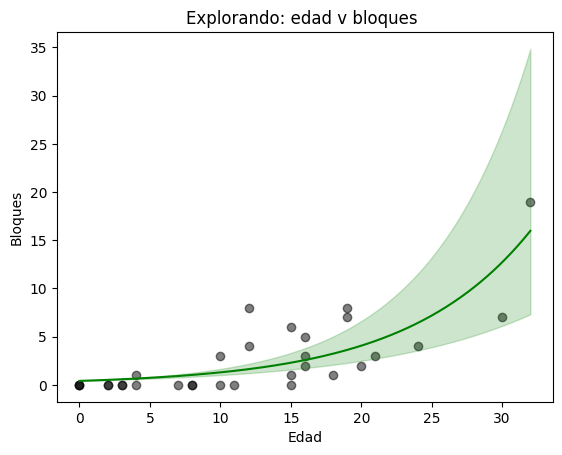

In [11]:
#muestro los errores en gráfico a partir de un IC.95 para b1 a b0 constante
mu_alto = np.exp(b0 + (b1 + se_b1 *1.96) * x_range)
mu_bajo = np.exp(b0 + (b1 - se_b1 *1.96) * x_range)

fig, ax = plt.subplots()
ax.scatter(X, Y, alpha=0.5,color='k')
ax.plot(x_range,poisson_fit,color='g')
ax.fill_between(x_range, mu_bajo, mu_alto, alpha=0.2,color = 'g')

ax.set_xlabel("Cantidad de ecualiptos cada 2 ha")
ax.set_ylabel("Cantidad de mieleros chillones")
ax.set_title("Explorando nminer: mieleros v eucaliptos ")
plt.show()